# Tactical Assist Analysis

**In this script, we to use the datasets from 'input.zip' to analyse tactical substitutions in soccer matches taken from European football league.**

Below are the steps:

-  **1. Importing libraries, modules, datasets**
-  **2. Goals Scored Analysis**
-  **3. Substitutions Analysis**
-  **4. Categorize Substitutions as Positive or Negative**
-  **5. Machine learning models to predict substitutions**

# 1. Importing libraries, modules and datasets for the analysis

In [1]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [2]:
events = pd.read_csv("input/events.csv")
game_info=pd.read_csv("input/ginf.csv")

In [3]:
events = events.merge(game_info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')
events.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,country,date
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0,germany,05-08-2011
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,05-08-2011
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,05-08-2011
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,05-08-2011
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0,germany,05-08-2011


In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_odsp        941009 non-null  object 
 1   id_event       941009 non-null  object 
 2   sort_order     941009 non-null  int64  
 3   time           941009 non-null  int64  
 4   text           941009 non-null  object 
 5   event_type     941009 non-null  int64  
 6   event_type2    214293 non-null  float64
 7   side           941009 non-null  int64  
 8   event_team     941009 non-null  object 
 9   opponent       941009 non-null  object 
 10  player         880009 non-null  object 
 11  player2        291310 non-null  object 
 12  player_in      51715 non-null   object 
 13  player_out     51738 non-null   object 
 14  shot_place     227459 non-null  float64
 15  shot_outcome   228498 non-null  float64
 16  is_goal        941009 non-null  int64  
 17  location       467067 non-nul

**Encoding the variables**

In [5]:
encoding = pd.read_table('input/dictionary.txt', delim_whitespace=False, names=('num','events'))
event_type=encoding[1:13]
event_type_2=encoding[14:18]

In [6]:
event_type

,num,events
1,0,Announcement
2,1,Attempt
3,2,Corner
4,3,Foul
5,4,Yellow card
6,5,Second yellow card
7,6,Red card
8,7,Substitution
9,8,Free kick won
10,9,Offside


# 2.  Assists Analysis

In [7]:
events = events[events['country'] == 'germany']
assists=events[events["event_type"]==1]

**Analysing assists against Time**

Text(0.5, 1.0, 'Number of assists Vs Time of match')

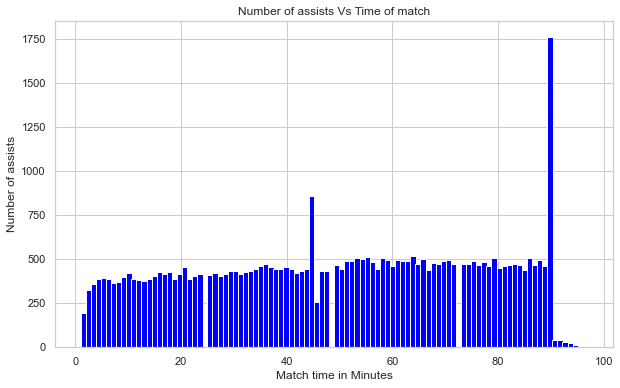

In [8]:
fig=plt.figure(figsize=(10,6))
#plt.hist(goals.time,width=1,bins=100,color="blue")   #100 so 1 bar per minute
plt.hist(assists.time,width=1,bins=100,color="blue")   #100 so 1 bar per minute
plt.xlabel("Match time in Minutes")
plt.ylabel("Number of assists")
plt.title("Number of assists Vs Time of match")

# 4. Categorize Assists as Positive or Negative

**merge player names to make partnerships and start analysis**

In [9]:
import math
import itertools
assists=events[events["event_type"]==1]
assists = assists.dropna(subset=['player','player2'])
assists['player_pair_sorted'] = assists.apply(lambda row: '-'.join(sorted([str(row['player']), str(row['player2'])])), axis=1)
assists.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,country,date,player_pair_sorted
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0,germany,05-08-2011,gokhan tore-mladen petric
11,UFot0hit/,UFot0hit12,12,14,Attempt missed. Shinji Kagawa (Borussia Dortmu...,1,12.0,1,Borussia Dortmund,Hamburg SV,shinji kagawa,mario gotze,NaN,NaN,13.0,2.0,0,15.0,1.0,1,1.0,0,germany,05-08-2011,mario gotze-shinji kagawa
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,kevin grosskreutz,mario gotze,NaN,NaN,4.0,1.0,1,9.0,2.0,1,1.0,0,germany,05-08-2011,kevin grosskreutz-mario gotze
18,UFot0hit/,UFot0hit19,19,25,Shinji Kagawa (Borussia Dortmund) hits the rig...,1,12.0,1,Borussia Dortmund,Hamburg SV,shinji kagawa,lukasz piszczek,NaN,NaN,7.0,4.0,0,3.0,1.0,1,1.0,0,germany,05-08-2011,lukasz piszczek-shinji kagawa
22,UFot0hit/,UFot0hit23,23,26,Attempt saved. Mats Hummels (Borussia Dortmund...,1,12.0,1,Borussia Dortmund,Hamburg SV,mats hummels,chris lowe,NaN,NaN,5.0,1.0,0,3.0,3.0,2,1.0,0,germany,05-08-2011,chris lowe-mats hummels


In [10]:
#Use Label Encoder module to change the string (player names, team names) to labels/numbers
from sklearn.preprocessing import LabelEncoder
def df_encoder(df):
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    label_encoder = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = label_encoder.fit_transform(df[feature])
        except:
            print('Unable to encode :', feature)
    return df

In [11]:

print(assists.head())
#assists.to_csv('assists_full.csv', index=False)

#labeled_assist = df_encoder(assists)
#print(labeled_assist.head())

#fig=plt.figure(figsize=(20,9))
#plt.hist(labeled_assist.player_pair,width=1,bins=100,color="blue")   
#plt.hist(labeled_assist.player_pair,bins=598,color="blue")   
#plt.xlabel("Player pair info")
#plt.ylabel("Number of attempts")
#plt.title("Number of attempts Vs player pair details")

      id_odsp    id_event  sort_order  time                                               text  event_type  event_type2  side         event_team           opponent             player          player2 player_in player_out  shot_place  shot_outcome  is_goal  location  bodypart  assist_method  situation  fast_break  country        date             player_pair_sorted
0   UFot0hit/   UFot0hit1           1     2  Attempt missed. Mladen Petric (Hamburg) left f...           1         12.0     2         Hamburg SV  Borussia Dortmund      mladen petric      gokhan tore       NaN        NaN         6.0           2.0        0       9.0       2.0              1        1.0           0  germany  05-08-2011      gokhan tore-mladen petric
11  UFot0hit/  UFot0hit12          12    14  Attempt missed. Shinji Kagawa (Borussia Dortmu...           1         12.0     1  Borussia Dortmund         Hamburg SV      shinji kagawa      mario gotze       NaN        NaN        13.0           2.0        0      15.0   

In [12]:
assists['player_pair_sorted'].value_counts()[assists['player_pair_sorted'].value_counts() > 10]

gonzalo castro-stefan kiessling        87
arjen robben-thomas muller             85
kevin volland-roberto firmino          72
marco reus-pierreemerick aubameyang    65
marco reus-robert lewandowski          64
                                       ..
kevin de bruyne-zlatko junuzovic       11
jonathan schmid-julian schuster        11
jerome gondorf-marcel heller           11
johannes geis-niko bungert             11
daniel schwaab-filip kostic            11
Name: player_pair_sorted, Length: 583, dtype: int64

In [13]:
assists['player_pair_sorted'].value_counts()

gonzalo castro-stefan kiessling        87
arjen robben-thomas muller             85
kevin volland-roberto firmino          72
marco reus-pierreemerick aubameyang    65
marco reus-robert lewandowski          64
                                       ..
aleksandar ignjovski-lennart thy        1
sebastian langkamp-tobias werner        1
gibril sankoh-tobias werner             1
lorenzo davids-marcel ndjeng            1
erik jendrisek-jan rosenthal            1
Name: player_pair_sorted, Length: 7919, dtype: int64

In [14]:
assists['player_pair_count'] = assists.groupby('player_pair_sorted')['player_pair_sorted'].transform('count')

In [15]:
assists['positive_assist'] = assists['player_pair_count'].map(lambda x: 1 if x > 5 else 0)
assists.head()


,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,country,date,player_pair_sorted,player_pair_count,positive_assist
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0,germany,05-08-2011,gokhan tore-mladen petric,4,0
11,UFot0hit/,UFot0hit12,12,14,Attempt missed. Shinji Kagawa (Borussia Dortmu...,1,12.0,1,Borussia Dortmund,Hamburg SV,shinji kagawa,mario gotze,NaN,NaN,13.0,2.0,0,15.0,1.0,1,1.0,0,germany,05-08-2011,mario gotze-shinji kagawa,8,1
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,kevin grosskreutz,mario gotze,NaN,NaN,4.0,1.0,1,9.0,2.0,1,1.0,0,germany,05-08-2011,kevin grosskreutz-mario gotze,11,1
18,UFot0hit/,UFot0hit19,19,25,Shinji Kagawa (Borussia Dortmund) hits the rig...,1,12.0,1,Borussia Dortmund,Hamburg SV,shinji kagawa,lukasz piszczek,NaN,NaN,7.0,4.0,0,3.0,1.0,1,1.0,0,germany,05-08-2011,lukasz piszczek-shinji kagawa,13,1
22,UFot0hit/,UFot0hit23,23,26,Attempt saved. Mats Hummels (Borussia Dortmund...,1,12.0,1,Borussia Dortmund,Hamburg SV,mats hummels,chris lowe,NaN,NaN,5.0,1.0,0,3.0,3.0,2,1.0,0,germany,05-08-2011,chris lowe-mats hummels,3,0


In [16]:
#assists['aggressive_assist'] = assists.groupby(['id_odsp', 'player_pair_sorted'])['player_pair_sorted'].transform('count')
#assists['aggressive_assist'] = assists['aggressive_assist'].apply(lambda x: 1 if x > 1 else 0)
#assists.head()

In [17]:
#player_goal_dict = assists.groupby('player_pair_sorted')['aggressive_assist'].max().to_dict()
#assists['positive_assist_new'] = assists['player_pair_sorted'].map(player_goal_dict)
#assists.head()

In [18]:
#Use Label Encoder module to change the string (player names, team names) to labels/numbers
from sklearn.preprocessing import LabelEncoder
def df_encoder(df):
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    label_encoder = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = label_encoder.fit_transform(df[feature])
        except:
            print('Unable to encode :', feature)
    return df

In [19]:
#call labelencoder function to encode the string values
#substitution_df_modified = assists

In [20]:
substitution_df_modified = assists
substitution_df_modified=substitution_df_modified.dropna(subset=['player_pair_sorted','player_pair_count'])
substitution_df_modified.drop(['text', 'id_event', 'sort_order', 'time', 'event_type', 'event_type2', 'side', 'player_in',
                      'player_out', 'player', 'player2', 'shot_place', 'shot_outcome', 'is_goal', 'location', 'bodypart',
                      'situation', 'fast_break','date','country'], axis=1, inplace=True)
substitution_df_modified.head()
substitution_df_modified_new = df_encoder(substitution_df_modified)
substitution_df_modified = substitution_df_modified_new

# 5. Machine learning models to predict assists

**import sklearn modules.**

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [22]:
#Split the X and Y dataframes
x_var=substitution_df_modified.iloc[:,0:-1]
y=substitution_df_modified['positive_assist'].tolist()
x_var.tail()

,id_odsp,event_team,opponent,assist_method,player_pair_sorted,player_pair_count
939948,1365,11,0,1,7905,8
939960,1365,0,11,1,4132,17
939964,1365,0,11,1,4106,12
939965,1365,11,0,1,3864,14
939966,1365,0,11,1,4106,12


In [23]:
#split the test and train values 80%, 20% split
x_train,x_test,y_train,y_test=train_test_split(x_var,y,test_size=0.2,random_state=0)

In [24]:
#x_test

In [25]:
#y_test

In [26]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

**Test accuracy of models.**

In [27]:
def acc_score(ml_model):
    return np.mean(cross_val_score(ml_model, x_train, y_train, cv=k_fold, scoring="accuracy"))

In [28]:
from sklearn.metrics import accuracy_score
def norm_score(ml_model):
    return (accuracy_score(y_train, ml_model.predict(x_train)))

**Function to get confusion matrix for each model.**

In [29]:
from sklearn.metrics import confusion_matrix
def confusion_matrix_model(model_used):
    con_matrix=confusion_matrix(y_train, model_used.predict(x_train))
    con_matrix=pd.DataFrame(con_matrix)
    con_matrix.columns=["Expected Positive Substitution", "Expected Negative Substitution"]
    con_matrix.index=["Actual Positive Substitution", "Actual Negative Substitution"]
    return con_matrix

**Logistic Regression**

In [30]:
logistic_reg=LogisticRegression()
logistic_reg.fit(x_train,y_train)
print("Logistic Regression Accuracy (without Cross Validation): "+str(norm_score(logistic_reg)))
print("Logistic Regression Accuracy (with Cross Validation): "+str(acc_score(logistic_reg)))
confusion_matrix_model(logistic_reg)

Logistic Regression Accuracy (without Cross Validation): 0.947157300151447
Logistic Regression Accuracy (with Cross Validation): 0.9461339992081319


,Expected Positive Substitution,Expected Negative Substitution
Actual Positive Substitution,9642,763
Actual Negative Substitution,528,13498


score : 0.9490831696136215


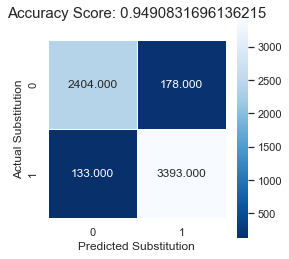

In [31]:
from sklearn import metrics
score = logistic_reg.score(x_test, y_test)
print("score :", score)
predictions = logistic_reg.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Substitution');
plt.xlabel('Predicted Substitution');
all_sample_title = 'Accuracy Score: {0}\n'.format(score)
plt.title(all_sample_title, size = 15);

**K-Nearest Neighbour Regression**

In [32]:
k_neighbour_classifier=KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='ball_tree', p=1, metric='minkowski')
k_neighbour_classifier.fit(x_train,y_train)
print("KNN Regression Accuracy (without cross validation): "+str(norm_score(k_neighbour_classifier)))
print("KNN Regression Accuracy (with cross validation): "+str(acc_score(k_neighbour_classifier)))
confusion_matrix_model(k_neighbour_classifier)

KNN Regression Accuracy (without cross validation): 1.0
KNN Regression Accuracy (with cross validation): 0.7711926858729274


,Expected Positive Substitution,Expected Negative Substitution
Actual Positive Substitution,10405,0
Actual Negative Substitution,0,14026


score : 0.7809430255402751


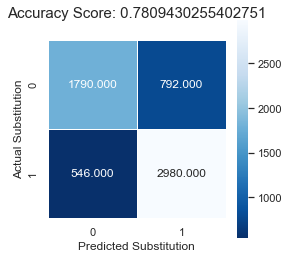

In [33]:
score = k_neighbour_classifier.score(x_test, y_test)
print("score :", score)
predictions = k_neighbour_classifier.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Substitution');
plt.xlabel('Predicted Substitution');
all_sample_title = 'Accuracy Score: {0}\n'.format(score)
plt.title(all_sample_title, size = 15);

**Support Vector Machine**

In [ ]:
svm_reg=svm.SVC(kernel='linear')
svm_reg.fit(x_train,y_train)
print("SVM Regression Accuracy (without cross validation): "+str(norm_score(svm_reg)))
#print("SVM Regression Accuracy (with cross validation): "+str(acc_score(svm_reg)))
confusion_matrix_model(svm_reg)

In [ ]:
score = svm_reg.score(x_test, y_test)
print("score :", score)
predictions = svm_reg.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Substitution');
plt.xlabel('Predicted Substitution');
all_sample_title = 'Accuracy Score: {0}\n'.format(score)
plt.title(all_sample_title, size = 15);

**Multinomial Naive Bayes**

In [ ]:
naive_bayes=MultinomialNB()
naive_bayes.fit(x_train,y_train)
print("Multinomial Naive Bayes Regression Accuracy (without cross validation): "+str(norm_score(naive_bayes)))
print("Multinomial Naive Bayes Regression Accuracy (with cross validation): "+str(acc_score(naive_bayes)))
confusion_matrix_model(naive_bayes)

In [ ]:
score = naive_bayes.score(x_test, y_test)
print("score :", score)
predictions = naive_bayes.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Substitution');
plt.xlabel('Predicted Substitution');
all_sample_title = 'Accuracy Score: {0}\n'.format(score)
plt.title(all_sample_title, size = 15);

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 200) 
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)

score = clf.score(x_test, y_test)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Substitution');
plt.xlabel('Predicted Substitution');
all_sample_title = 'Accuracy Score: {0}\n'.format(score)
plt.title(all_sample_title, size = 15);

#### **Decision Tree Regression**

In [ ]:
decision_tree=DecisionTreeClassifier()
decision_tree.fit(x_train,y_train)
print("Decision Tree Regression Accuracy (without cross validation): "+str(norm_score(decision_tree)))
print("Decision Tree Regression Accuracy (with cross validation): "+str(acc_score(decision_tree)))
confusion_matrix_model(decision_tree)


In [ ]:
score = decision_tree.score(x_test, y_test)
print("score :", score)
predictions = decision_tree.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Substitution');
plt.xlabel('Predicted Substitution');
all_sample_title = 'Accuracy Score: {0}\n'.format(score)
plt.title(all_sample_title, size = 15);